In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

In [80]:
def detectar_outliers_iqr(df, columna, factor=1.5):
    """
    Detecta outliers usando el método IQR.
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame de pandas
    columna : str
        Nombre de la columna numérica
    factor : float, default=1.5
        Factor multiplicador del IQR (1.5 estándar, 3.0 más conservador)
    
    Retorna:
    --------
    dict : Diccionario con información de outliers
    """
    # Calcular Q1, Q3 e IQR
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcular límites
    limite_inferior = Q1 - factor * IQR
    limite_superior = Q3 + factor * IQR
    
    # Identificar outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    
    return {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'limite_inferior': limite_inferior,
        'limite_superior': limite_superior,
        'n_outliers': len(outliers),
        'outliers': outliers,
        'indices_outliers': outliers.index.tolist()
    }

print("✅ Función detectar_outliers_iqr creada")

✅ Función detectar_outliers_iqr creada


## Cargar la base de datos y los diccionarios

In [81]:
df = pd.read_csv("./cs-construction.csv", index_col="Unnamed: 0")
df.sample(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
56430,1,0.937856,52,2,0.709525,3600.0,10,0,2,2,0.0
102439,0,0.000000,25,1,0.058916,1900.0,2,0,0,0,0.0
1962,0,0.000000,60,0,0.624692,3652.0,9,0,2,0,0.0
133178,0,0.044149,76,0,0.022599,2300.0,6,0,0,0,0.0
35342,0,0.090462,56,0,0.015186,5333.0,6,0,0,0,1.0
45788,0,0.001111,76,0,0.244189,4000.0,6,0,1,0,0.0
75797,0,0.988024,53,1,0.771734,5900.0,8,1,2,0,3.0
80078,0,0.411133,64,0,0.111160,4542.0,5,0,0,0,0.0
84151,0,0.157920,56,0,34.000000,1.0,1,0,0,0,0.0
99492,0,0.418012,34,0,0.481213,4550.0,12,0,2,0,1.0


In [82]:
# Cargar diccionario
pd.options.display.max_colwidth = None 
dicc = pd.read_excel("./cs-Data Dictionary.xls", skiprows=1)
dicc

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: fl

In [84]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [85]:
# Verificar la cantidad de valores vacios
print(df.isnull().sum())

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


## MonthlyIncome

SeriousDlqin2yrs
0    93.316
1     6.684
Name: count, dtype: float64


<Axes: xlabel='SeriousDlqin2yrs'>

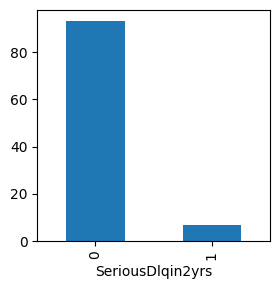

In [86]:
# Estadistica de impagos
aux = 100*df["SeriousDlqin2yrs"].value_counts()/len(df)
print(aux)

plt.figure(figsize=(3,3))
aux.plot(kind="bar")

SeriousDlqin2yrs
0    94.386331
1     5.613669
Name: count, dtype: float64


<Axes: xlabel='SeriousDlqin2yrs'>

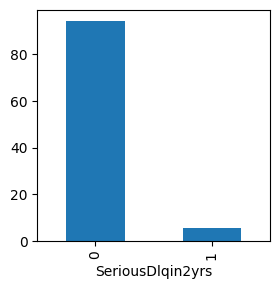

In [87]:
# Hago lo mismo pero centradome en los casos donde haya missing en MothnIncome
df2 = df[df["MonthlyIncome"].isna()]
aux2 = (100*df2["SeriousDlqin2yrs"].value_counts()/len(df2))
print(aux2)

plt.figure(figsize=(3,3))
aux2.plot(kind="bar")

a nivel de pagos impagos de credito, las filas con missing value en MonthlyIncome tiene un compartamiento que las otras
Por tanto, si elimino las filas con nans en MonthlyIncome, no estoy sesgando el dataset

In [88]:
df_prueba2 = df.copy()
df_prueba2.dropna(subset=["MonthlyIncome"], inplace=True) # elimina todas las filas nan en MonthlyIncome

In [89]:
df_prueba2.isna().sum()
# si se elimina MonthlyIncome tambien se elimina los nan de Numberofdependents, puede que esten relacionadas

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [90]:
df_prueba2.describe().T[["count", "min", "max", "mean", "std"]]

,count,min,max,mean,std
SeriousDlqin2yrs,120269.0,0.0,1.0,0.069486,0.254280
RevolvingUtilizationOfUnsecuredLines,120269.0,0.0,50708.0,5.899873,257.040685
age,120269.0,0.0,103.0,51.289792,14.426684
NumberOfTime30-59DaysPastDueNotWorse,120269.0,0.0,98.0,0.381769,3.499234
DebtRatio,120269.0,0.0,61106.5,26.598777,424.446457
MonthlyIncome,120269.0,0.0,3008750.0,6670.221237,14384.674215
NumberOfOpenCreditLinesAndLoans,120269.0,0.0,58.0,8.758475,5.172835
NumberOfTimes90DaysLate,120269.0,0.0,98.0,0.211925,3.465276
NumberRealEstateLoansOrLines,120269.0,0.0,54.0,1.054519,1.149273
NumberOfTime60-89DaysPastDueNotWorse,120269.0,0.0,98.0,0.187829,3.447901


<Axes: xlabel='age'>

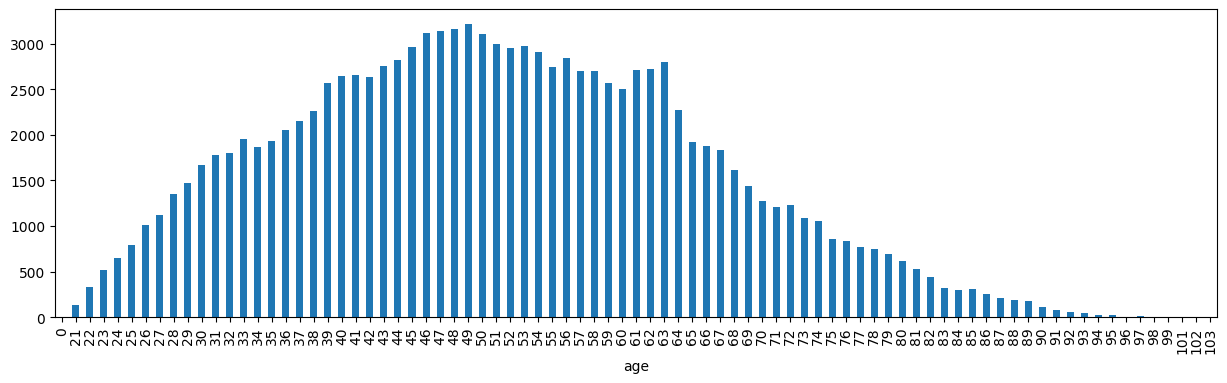

In [91]:
plt.figure(figsize=(15, 4))
aux = df_prueba2["age"].value_counts()
aux[sorted(aux.index)].plot(kind="bar")

## Age

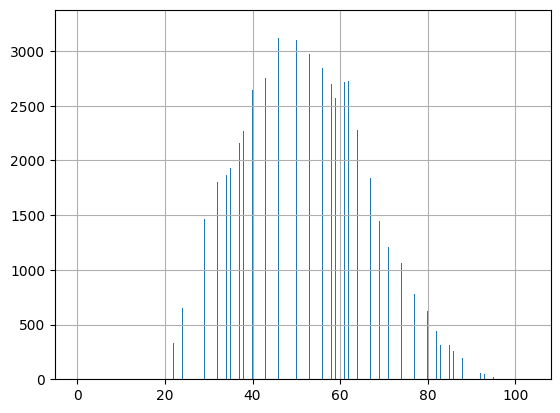

In [92]:
df_prueba2["age"].hist(bins=1000);

In [93]:
# quitar edades menores de 21 y mayores de 70
df_prueba2 = df_prueba2[ (df_prueba2["age"] >= 21) & (df_prueba2["age"] <= 70) ]

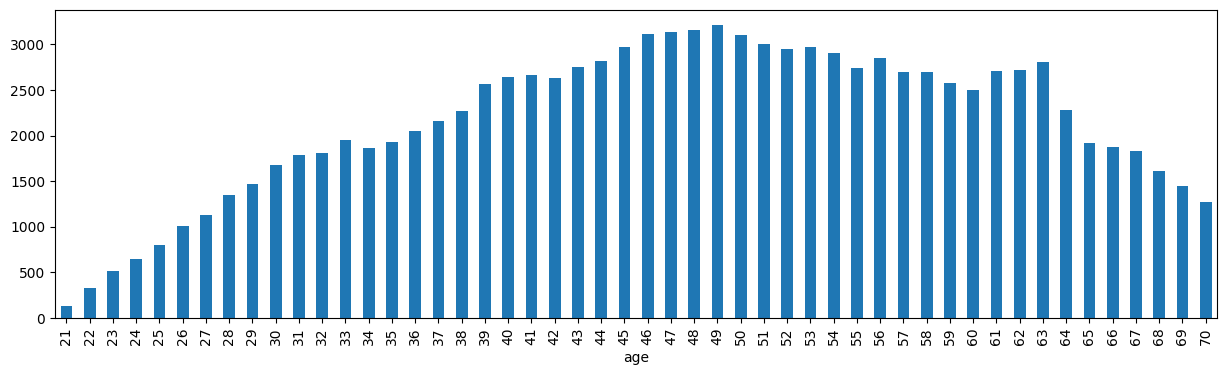

In [94]:
plt.figure(figsize=(15, 4))
aux = df_prueba2["age"].value_counts()
aux[sorted(aux.index)].plot(kind="bar");

In [95]:
df_prueba2.describe().T[["count", "min", "max", "mean", "std"]]

,count,min,max,mean,std
SeriousDlqin2yrs,108029.0,0.0,1.0,0.074397,0.262417
RevolvingUtilizationOfUnsecuredLines,108029.0,0.0,50708.0,6.255173,268.243857
age,108029.0,21.0,70.0,48.326227,11.919743
NumberOfTime30-59DaysPastDueNotWorse,108029.0,0.0,98.0,0.408779,3.663487
DebtRatio,108029.0,0.0,60212.0,27.389805,395.720414
MonthlyIncome,108029.0,0.0,3008750.0,6795.076637,14932.977759
NumberOfOpenCreditLinesAndLoans,108029.0,0.0,58.0,8.762425,5.161635
NumberOfTimes90DaysLate,108029.0,0.0,98.0,0.230827,3.630604
NumberRealEstateLoansOrLines,108029.0,0.0,54.0,1.093753,1.157532
NumberOfTime60-89DaysPastDueNotWorse,108029.0,0.0,98.0,0.204380,3.612534


## NumberOfTime30-59DaysPastDueNotWorse

In [96]:
df_prueba2["NumberOfTime30-59DaysPastDueNotWorse"].value_counts()

NumberOfTime30-59DaysPastDueNotWorse
0     88828
1     12740
2      3759
3      1461
4       615
5       274
98      142
6       123
7        44
8        23
9         9
96        4
10        3
12        2
13        1
11        1
Name: count, dtype: int64

<Axes: xlabel='NumberOfTime30-59DaysPastDueNotWorse'>

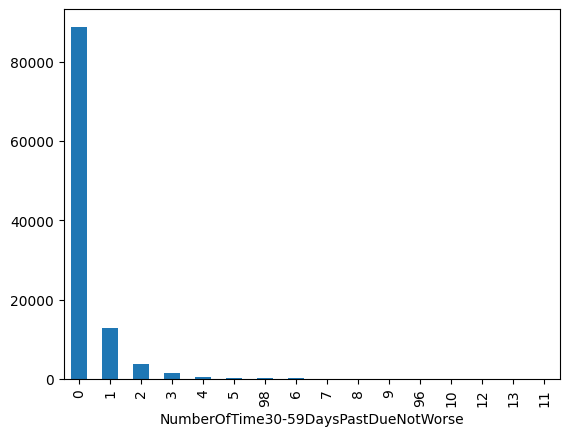

In [97]:
# Nos fijamos en DaysPastDueNotWorse puesto que todas tienen un maximo de 98, por tanto, algo raro
df_prueba2["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().plot(kind="bar")

In [98]:
out = detectar_outliers_iqr(df_prueba2, columna="NumberOfTime30-59DaysPastDueNotWorse")
out["outliers"]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
14,1,0.964673,40,3,0.382965,13700.0,9,3,1,1,2.0
30,0,0.392995,58,2,0.436103,5500.0,15,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149957,0,0.906819,30,2,0.168238,3500.0,4,0,0,0,0.0
149962,1,0.920107,31,1,0.176732,1125.0,4,1,0,0,0.0
149975,0,0.962721,61,2,0.603479,5000.0,11,0,1,0,0.0
149979,0,0.917635,52,2,0.259496,2500.0,4,0,0,0,0.0


In [99]:
vars_retrasos = ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfTimes90DaysLate"]
df_prueba2[df_prueba2["NumberOfTime30-59DaysPastDueNotWorse"] >= 96][vars_retrasos]

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate
1734,98,98,98
4418,98,98,98
4706,98,98,98
5074,98,98,98
6281,98,98,98
...,...,...,...
144231,98,98,98
144587,98,98,98
146254,98,98,98
147129,98,98,98


In [100]:
df_prueba2["NumberOfTime30-59DaysPastDueNotWorse"].value_counts()

NumberOfTime30-59DaysPastDueNotWorse
0     88828
1     12740
2      3759
3      1461
4       615
5       274
98      142
6       123
7        44
8        23
9         9
96        4
10        3
12        2
13        1
11        1
Name: count, dtype: int64

In [101]:
df_prueba2["NumberOfTime60-89DaysPastDueNotWorse"].value_counts()

NumberOfTime60-89DaysPastDueNotWorse
0     102015
1       4590
2        881
3        259
98       142
4         84
5         28
6         16
7          6
96         4
8          2
11         1
9          1
Name: count, dtype: int64

In [102]:
df_prueba2["NumberOfTimes90DaysLate"].value_counts()

NumberOfTimes90DaysLate
0     101556
1       4129
2       1195
3        521
4        238
98       142
5        101
6         62
7         28
8         16
9         14
10         8
11         4
96         4
13         4
15         2
14         2
12         2
17         1
Name: count, dtype: int64

In [103]:
# el 96 y 98 son missing data por tanto lo podemos quitar
df_prueba2 = df_prueba2[df_prueba2["NumberOfTime30-59DaysPastDueNotWorse"] < 96]

In [104]:
df_prueba2.describe().T[["count", "min", "max", "mean", "std"]]

,count,min,max,mean,std
SeriousDlqin2yrs,107883.0,0.0,1.0,0.073728,0.261329
RevolvingUtilizationOfUnsecuredLines,107883.0,0.0,50708.0,6.262285,268.425237
age,107883.0,21.0,70.0,48.343835,11.909195
NumberOfTime30-59DaysPastDueNotWorse,107883.0,0.0,13.0,0.276781,0.739606
DebtRatio,107883.0,0.0,60212.0,27.426863,395.986811
MonthlyIncome,107883.0,0.0,3008750.0,6800.816625,14941.921271
NumberOfOpenCreditLinesAndLoans,107883.0,0.0,58.0,8.774265,5.155074
NumberOfTimes90DaysLate,107883.0,0.0,17.0,0.098588,0.509666
NumberRealEstateLoansOrLines,107883.0,0.0,54.0,1.095233,1.157615
NumberOfTime60-89DaysPastDueNotWorse,107883.0,0.0,11.0,0.072106,0.348840


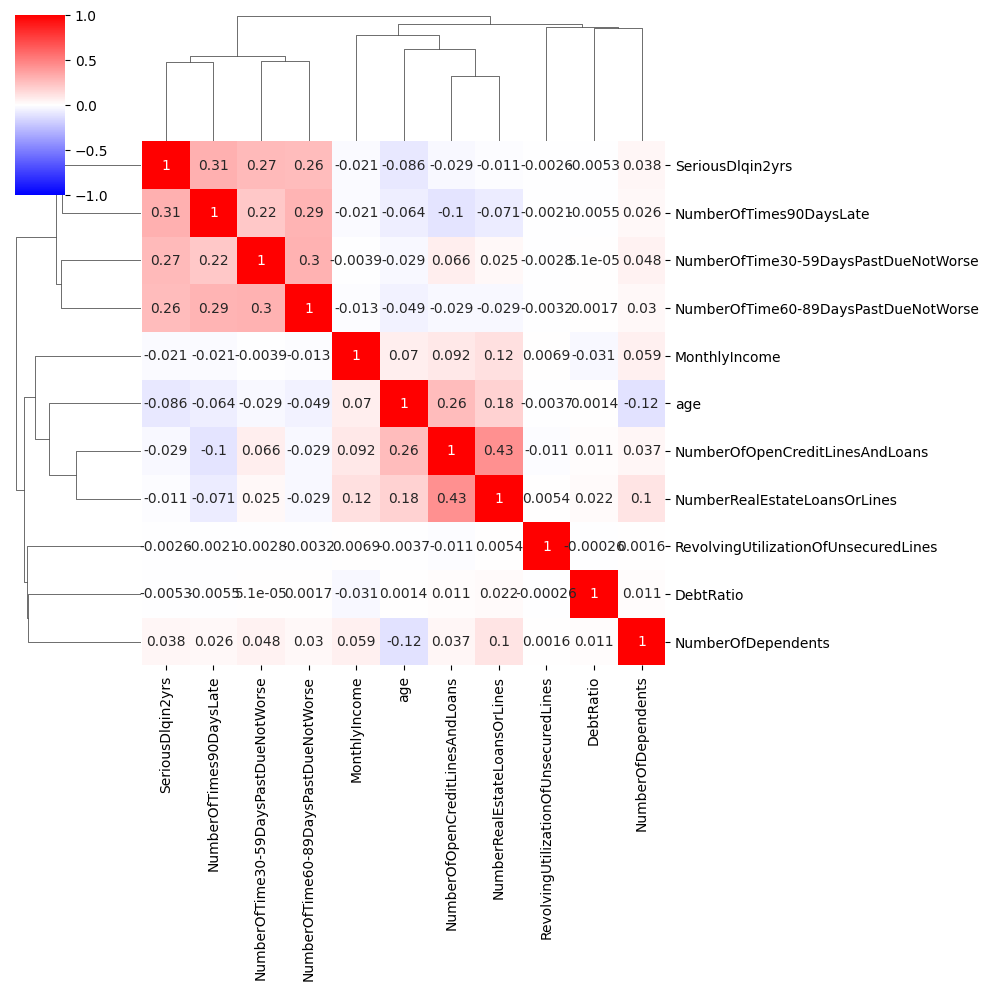

In [105]:
# Ver la correlacion entre las distintas variables
sns.clustermap(df_prueba2.corr(), cmap="bwr", vmin=-1, annot=True);

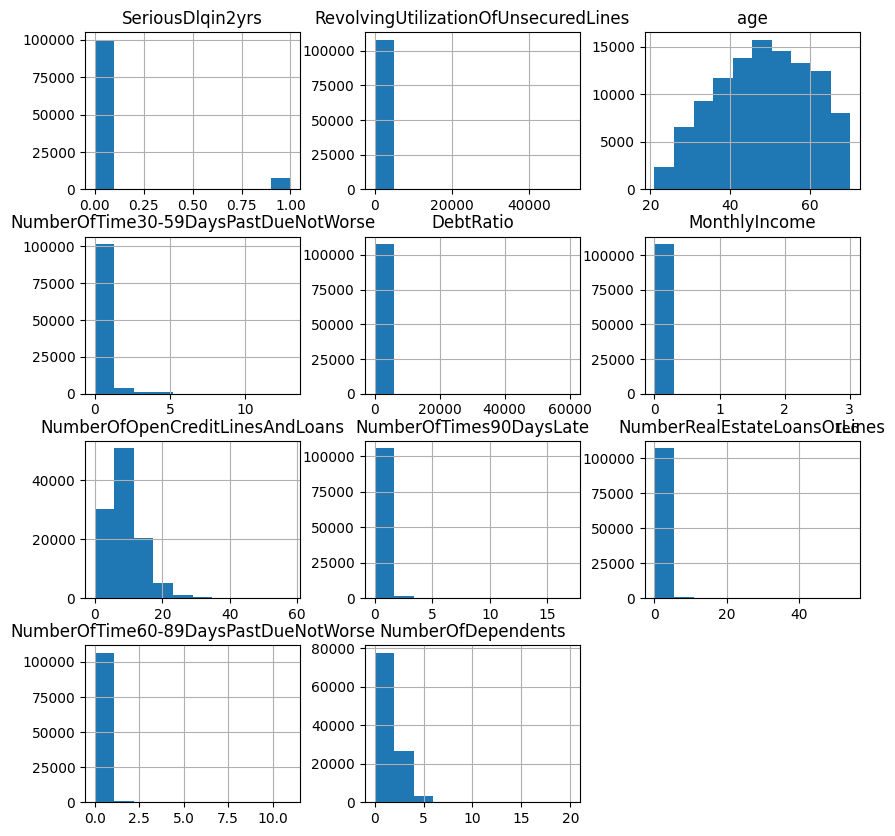

In [106]:
df_prueba2.hist(figsize=(10, 10));

<Axes: >

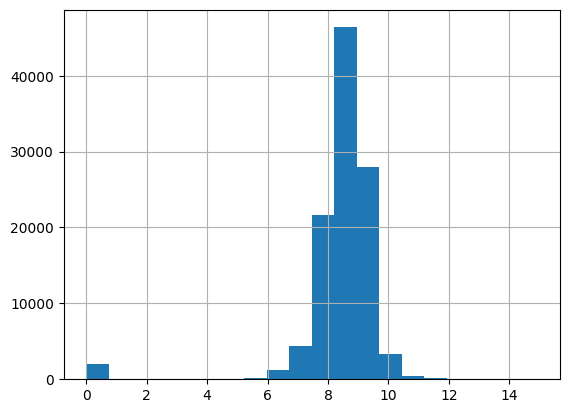

In [107]:
df_prueba2["MonthlyIncome"].apply(np.log1p).hist(bins=20)

In [108]:
out = detectar_outliers_iqr(df_prueba2, columna="MonthlyIncome")
out["outliers"]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0
46,0,0.000603,70,0,0.177787,16800.0,12,0,1,0,2.0
128,0,0.000000,59,0,0.218854,19167.0,13,0,2,0,0.0
197,0,0.762159,44,4,0.224466,21000.0,5,0,1,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
149862,0,0.089997,61,0,0.095543,17499.0,3,0,1,0,0.0
149894,0,0.000000,41,0,0.131958,25833.0,12,0,1,0,5.0
149907,0,0.056999,62,0,0.116106,17750.0,18,0,1,0,3.0
149945,0,0.291860,36,1,0.119287,24000.0,12,0,2,0,0.0


In [109]:
plt.figure(figsize=(10, 8))
salario_filtado = df_prueba2[df_prueba2["MonthlyIncome"] > 1000000]

salario_filtado


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
50641,0,0.469025,44,1,0.004537,1072500.0,9,0,2,0,1.0
73764,0,0.007328,52,0,0.001470,3008750.0,10,0,1,0,3.0
111366,0,0.163856,44,0,0.004013,1560100.0,12,0,4,0,2.0
137141,0,0.000000,68,0,0.002776,1794060.0,15,0,1,0,0.0


<Figure size 1000x800 with 0 Axes>

In [110]:
df_prueba2["MonthlyIncome"] = df_prueba2["MonthlyIncome"].apply(np.log1p)


<Axes: ylabel='Frequency'>

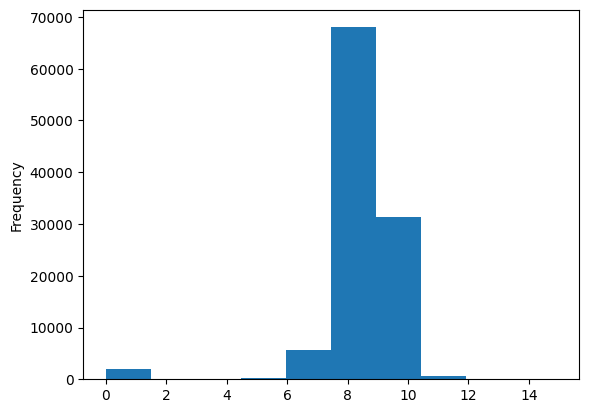

In [111]:
df_prueba2["MonthlyIncome"].plot(kind="hist")

## NumberOfDependents

In [112]:
df_prueba2.describe().T[["count", "min", "max", "mean", "std"]]

,count,min,max,mean,std
SeriousDlqin2yrs,107883.0,0.0,1.000000,0.073728,0.261329
RevolvingUtilizationOfUnsecuredLines,107883.0,0.0,50708.000000,6.262285,268.425237
age,107883.0,21.0,70.000000,48.343835,11.909195
NumberOfTime30-59DaysPastDueNotWorse,107883.0,0.0,13.000000,0.276781,0.739606
DebtRatio,107883.0,0.0,60212.000000,27.426863,395.986811
MonthlyIncome,107883.0,0.0,14.917036,8.430444,1.335852
NumberOfOpenCreditLinesAndLoans,107883.0,0.0,58.000000,8.774265,5.155074
NumberOfTimes90DaysLate,107883.0,0.0,17.000000,0.098588,0.509666
NumberRealEstateLoansOrLines,107883.0,0.0,54.000000,1.095233,1.157615
NumberOfTime60-89DaysPastDueNotWorse,107883.0,0.0,11.000000,0.072106,0.348840


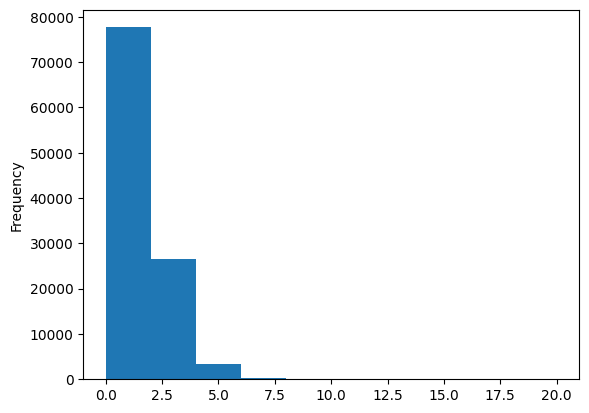

In [113]:
df_prueba2["NumberOfDependents"].plot(kind="hist");

In [114]:
df_prueba2["NumberOfDependents"].value_counts()

NumberOfDependents
0.0     55227
1.0     22460
2.0     17914
3.0      8714
4.0      2650
5.0       688
6.0       150
7.0        48
8.0        21
10.0        5
9.0         4
20.0        1
13.0        1
Name: count, dtype: int64

In [115]:
df_prueba2.loc[df_prueba2["NumberOfDependents"] == 20]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
6300,0,0.226616,40,1,0.576539,8.751,11,2,1,0,20.0


In [116]:
df_prueba2["NumberOfDependents"] = df_prueba2["NumberOfDependents"].astype("Int16")
df_prueba2["NumberOfDependents"].info()

<class 'pandas.core.series.Series'>
Index: 107883 entries, 1 to 150000
Series name: NumberOfDependents
Non-Null Count   Dtype
--------------   -----
107883 non-null  Int16
dtypes: Int16(1)
memory usage: 1.1 MB


## Pequeño modelo

In [117]:
# Crear una columna nueva para guardar si se concede un credito o no
# 1 = sin impagos graves → perfil bueno
# 0 = impagos → riesgo
df_prueba2["GoodCredit"] = (df_prueba2["SeriousDlqin2yrs"] == 0).astype("int")

In [118]:
df_prueba2["GoodCredit"].value_counts()


GoodCredit
1    99929
0     7954
Name: count, dtype: int64

In [119]:
df_prueba2[["SeriousDlqin2yrs", "GoodCredit"]].head()

,SeriousDlqin2yrs,GoodCredit
1,1,0
2,0,1
3,0,1
4,0,1
5,0,1


In [120]:
x = df_prueba2[[
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfTimes90DaysLate",
    "NumberRealEstateLoansOrLines",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents"
]]


In [121]:
# objetivo
y = df_prueba2["GoodCredit"]

In [122]:
# train / test
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [123]:
# Modelo
model = LogisticRegression(max_iter=200)
model.fit(x_train, y_train)

c:\Users\Brayan\Documents\datamecum_pruebas\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [124]:
# Predicción probabilidades
df_prueba2["prob_credito"] = model.predict_proba(x)[:,1]

In [125]:
df_prueba2.sort_values("prob_credito", ascending=False).head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,GoodCredit,prob_credito
127899,0,0.351737,63,0,60212.0,0.0,8,0,0,1,0,1,1.000000
146311,0,0.895729,52,2,49112.0,0.0,16,0,1,0,0,1,1.000000
63856,0,0.000000,66,0,25033.0,0.0,3,0,0,0,0,1,1.000000
19362,0,0.108889,48,0,25801.0,0.0,4,0,1,0,0,1,1.000000
25864,0,0.000000,38,0,20000.0,0.0,2,0,0,0,0,1,1.000000
91,0,0.039388,51,0,15466.0,0.0,7,0,0,0,0,1,0.999999
18229,0,0.002335,65,0,12778.0,0.0,4,0,0,0,1,1,0.999995
19558,0,0.019939,66,1,12707.0,0.0,22,0,4,0,2,1,0.999988
34780,0,0.026228,50,0,12018.0,0.0,16,0,3,0,0,1,0.999985
40758,0,0.413105,69,1,11902.0,0.0,23,0,3,0,0,1,0.999984


In [126]:
model.score(x_train, y_train), model.score(x_test, y_test)

(0.9295182258475656, 0.930388839968485)

In [127]:
y_pred_train = model.predict_proba(x_train)[:,1]
y_pred_test  = model.predict_proba(x_test)[:,1]

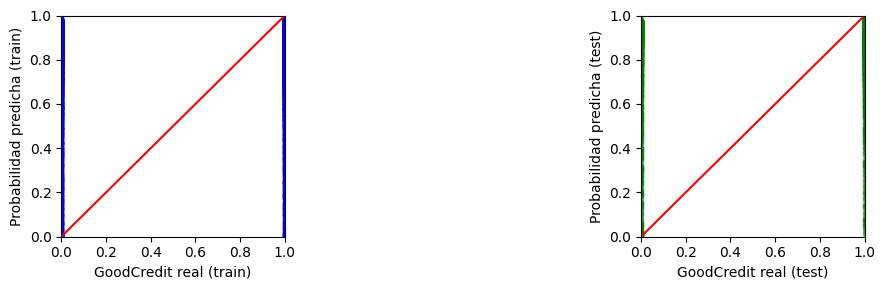

In [128]:
maximo = 1

plt.figure(figsize=(9, 3))

# TRAIN
plt.subplot(1, 3, 1)
plt.plot(y_train, y_pred_train, ".b", alpha=0.2)
plt.xlabel("GoodCredit real (train)")
plt.ylabel("Probabilidad predicha (train)")
plt.plot([0, maximo], [0, maximo], "r")
plt.xlim([0, maximo])
plt.ylim([0, maximo])

# TEST
plt.subplot(1, 3, 3)
plt.plot(y_test, y_pred_test, ".g", alpha=0.2)
plt.xlabel("GoodCredit real (test)")
plt.ylabel("Probabilidad predicha (test)")
plt.plot([0, maximo], [0, maximo], "r")
plt.xlim([0, maximo])
plt.ylim([0, maximo])

plt.tight_layout()
plt.show()

